In [4]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import random
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# 機械学習関連のライブラリ群
from sklearn.linear_model import LogisticRegression # ロジスティック回帰
from sklearn.neighbors import KNeighborsClassifier # K近傍法
from sklearn.svm import SVC # サポートベクターマシン
from sklearn.tree import DecisionTreeClassifier # 決定木
from sklearn.ensemble import RandomForestClassifier # ランダムフォレスト
from sklearn.ensemble import AdaBoostClassifier # AdaBoost
from sklearn.naive_bayes import GaussianNB # ナイーブ・ベイズ

#表示するテーブルの最大行と最大列を指定
pd.options.display.max_columns = 100
pd.options.display.max_rows = 999

seed = 42
# 乱数初期化
random.seed(seed)
np.random.seed(seed)

# データの読み込み
train = pd.read_csv('src/train.csv', index_col=0)
test = pd.read_csv('src/test.csv', index_col=0)
sample_submit = pd.read_csv('src/sample_submit.csv')

In [5]:
# 訓練データの欠損値の個数をカウント
print('train data')
print(train.isnull().sum())

train data
Age         0
Gender      0
T_Bil       0
D_Bil       0
ALP         0
ALT_GPT     0
AST_GOT     0
TP          0
Alb         0
AG_ratio    4
disease     0
dtype: int64


In [12]:
# 欠損地を最頻値で補完
train = train.fillna(train.mode().iloc[0])
print('train data')
print(train.isnull().sum())

train data
Age         0
Gender      0
T_Bil       0
D_Bil       0
ALP         0
ALT_GPT     0
AST_GOT     0
TP          0
Alb         0
AG_ratio    0
disease     0
dtype: int64


In [6]:
# テストデータの欠損値の個数をカウント
print('test data')
print(test.isnull().sum())

test data
Age         0
Gender      0
T_Bil       0
D_Bil       0
ALP         0
ALT_GPT     0
AST_GOT     0
TP          0
Alb         0
AG_ratio    0
dtype: int64


In [13]:
# データ処理のためtrainとtestを結合
train_data = pd.concat([train, test])
print('trainサイズ:', len(train))
print('testサイズ:', len(test))
print('train_dataサイズ:', len(train_data))

trainサイズ: 891
testサイズ: 382
train_dataサイズ: 1273


In [14]:
train_data.dtypes

Age           int64
Gender       object
T_Bil       float64
D_Bil       float64
ALP         float64
ALT_GPT     float64
AST_GOT     float64
TP          float64
Alb         float64
AG_ratio    float64
disease     float64
dtype: object

In [15]:
# オブジェクトカラムをラベルエンコーディング
object_columns = train_data.select_dtypes(include=['object']).columns.tolist()
le = LabelEncoder()
for column in object_columns:
    train_data[column] = le.fit_transform(train_data[column])
    # train[column] = train[column].astype('cateogyr')
train_data[object_columns] = train_data[object_columns].astype('category')
train_data.dtypes

Age            int64
Gender      category
T_Bil        float64
D_Bil        float64
ALP          float64
ALT_GPT      float64
AST_GOT      float64
TP           float64
Alb          float64
AG_ratio     float64
disease      float64
dtype: object

### いろんな無機械学習手法を比較する

<Axes: >

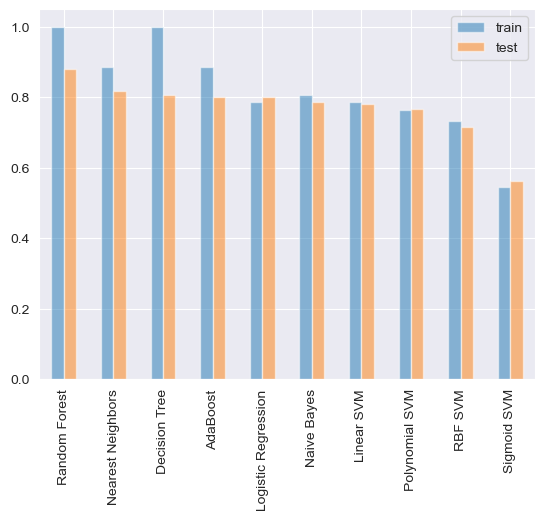

In [22]:
names = ["Logistic Regression", "Nearest Neighbors", 
         "Linear SVM", "Polynomial SVM", "RBF SVM", "Sigmoid SVM", 
         "Decision Tree","Random Forest", "AdaBoost", "Naive Bayes", 
]

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    SVC(kernel="linear"),
    SVC(kernel="poly"),
    SVC(kernel="rbf"),
    SVC(kernel="sigmoid"),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB()
]

X = train_data.drop('disease', axis=1).iloc[: len(train)]
y = train_data['disease'].iloc[: len(train)]

X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y, shuffle=True,
                                                  train_size=0.7,
                                                  random_state=seed,
                                                  stratify=y)

result = []
for name, clf in zip(names, classifiers): # 指定した複数の分類機を順番に呼び出す
    clf.fit(X_train, y_train) # 学習
    score1 = roc_auc_score(clf.predict(X_train), y_train)
        #clf.score(X_train, y_train)) # 正解率（train）の算出
    score2 = roc_auc_score(clf.predict(X_val), y_val) # 正解率（test）の算出
    result.append([score1, score2]) # 結果の格納

# test の正解率の大きい順に並べる
# df_result = pd.DataFrame(result, columns=['train', 'test'], index=names).sort('test', ascending=False)
# もし上のコードが動かない場合、以下のコーを試してみてください。
df_result = pd.DataFrame(result, columns=['train', 'test'], index=names).sort_values('test', ascending=False)

df_result.plot(kind='bar', alpha=0.5, grid=True)

In [39]:
#ハイパーパラメータのチューニング
import optuna
from sklearn.metrics import mean_squared_error

# MeanF1スコアを格納するリスト
AUC_scores = []

X = train_data.drop('disease', axis=1).iloc[: len(train)]
y = train_data['disease'].iloc[: len(train)]

X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y, shuffle=True,
                                                  train_size=0.7,
                                                  random_state=seed,
                                                  stratify=y)


def objective(trial):
    params = {
        # 'random_seed': seed,
        # 'objective':'binary', # 'binary',
        # 'verbosity': -1,
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']), #'multy_logloss',
        # 'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 1.0),
        # 'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        # 'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        # 'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        # 'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        # 'max_bin': trial.suggest_int('max_bin', 255, 500),
        # 'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        # 'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'n_estimators': trial.suggest_int('n_estimators', 5, 300),
        'max_features': trial.suggest_int('max_features', 1, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 100),
        'min_samples_leaf': trial.suggest_int('min_samples_split', 1, 100),
    }

    # train_rfc = lgb.Dataset(X_train, label=y_train)
    # val_lgb = lgb.Dataset(X_val, label=y_val)
    model = RandomForestClassifier(**params,
                                   verbose=False,
                                   n_jobs=-1,
                                   random_state=seed)
    model.fit(X_train, y_train)

    y_pred_valid_prob = model.predict(X_val)# , num_iteration=model.best_iteration)
    # y_pred_valid = np.where(y_pred_valid_prob < 0.5, 0, 1)
    # score = np.sqrt(mean_squared_error(y_val, y_pred_valid_prob))
    score = roc_auc_score(y_val, y_pred_valid_prob)
    return score


study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.RandomSampler(seed=seed))
study.optimize(objective, n_trials=1000)
optimized_params = study.best_params
print(optimized_params)

[I 2024-05-02 14:40:27,212] A new study created in memory with name: no-name-c4b7f496-1dea-4fb4-a0f4-1523c1b60cc9
[I 2024-05-02 14:40:27,501] Trial 0 finished with value: 0.8322742474916389 and parameters: {'criterion': 'entropy', 'n_estimators': 221, 'max_features': 60, 'min_samples_split': 17, 'max_depth': 18}. Best is trial 0 with value: 0.8322742474916389.
[I 2024-05-02 14:40:27,690] Trial 1 finished with value: 0.8433667781493869 and parameters: {'criterion': 'entropy', 'n_estimators': 182, 'max_features': 71, 'min_samples_split': 4, 'max_depth': 98}. Best is trial 1 with value: 0.8433667781493869.
[I 2024-05-02 14:40:27,760] Trial 2 finished with value: 0.8388517279821628 and parameters: {'criterion': 'gini', 'n_estimators': 58, 'max_features': 19, 'min_samples_split': 32, 'max_depth': 54}. Best is trial 1 with value: 0.8433667781493869.
[I 2024-05-02 14:40:27,979] Trial 3 finished with value: 0.8388517279821628 and parameters: {'criterion': 'gini', 'n_estimators': 186, 'max_feat

{'criterion': 'gini', 'n_estimators': 162, 'max_features': 60, 'min_samples_split': 2, 'max_depth': 48}


In [46]:
#交差検証

params = {
        # 'random_state': seed,
    # 'objective': 'binary',
    # 'verbosity': -1,
}
# パラメータを最適化したもので上書き
params |= optimized_params

# クラスの比率が同じになるように分割
cv = StratifiedKFold(n_splits=400, random_state=seed, shuffle=True)

# AUCスコアを格納するリスト
AUC_scores = []

# 訓練データ
X = train_data.drop('disease', axis=1).iloc[: len(train)]
y = train_data['disease'].iloc[: len(train)]


rfc_model = RandomForestClassifier(**params,
                           verbose=True,
                           n_jobs=-1,
                           random_state=seed)
for train_index, val_index in cv.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    rfc_model.fit(X_train, y_train)
    y_val_pred_prob = rfc_model.predict(X_val)
    
    # # 検証データで予測
    y_pred = y_val_pred_prob
    
    # AUC scoreを計算してリストに追加
    AUC_score = roc_auc_score(y_val, y_pred)
    AUC_scores.append(AUC_score)

# スコアを表示
# print('Mean AUC scores:', AUC_scores)
print('Average AUC Score:', np.mean(AUC_scores))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 162 out of 162 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 162 out of 162 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parall

Average AUC Score: 0.888125


[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 162 out of 162 | elapsed:    0.0s finished


In [51]:
X_test = train_data.drop('disease', axis=1).iloc[len(train):]

y_test = pd.DataFrame(rfc_model.predict(X_test))

print('判定結果')
print('0:', np.count_nonzero(y_test == 0), '1:', np.count_nonzero(y_test == 1))
y_test

判定結果
0: 213 1: 169


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 162 out of 162 | elapsed:    0.1s finished


,0
0,0.0
1,1.0
2,0.0
3,1.0
4,0.0
5,1.0
6,0.0
7,0.0
8,0.0
9,0.0


In [52]:
submit = pd.DataFrame(train_data['disease'].iloc[len(train):])
submit['disease'] = y_pred
submit = submit.astype('int')
submit.to_csv('rfc_submit.csv', index=True, header=False)
submit

,disease
id,
891,0
892,1
893,0
894,1
895,0
896,1
897,0
898,0
899,0


In [143]:
# submission.csvの提出
# !signate submit --competition-id=1247 submission.csv --note LGB**51 # ここにコメント残せる